# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import functools
import itertools
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import wilcoxon, kendalltau
from utils import plot_longitudinal, get_diversity

# Set constants

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load data

In [3]:
study = "P65"

In [4]:
gmhi2 = load(os.path.join(config.MODEL_DIR, "gmhi2_model.joblib"))
gmhi2

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [5]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features_val.csv"), index_col=[0, 1]).loc[study]
X.head()

,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Thermoplasmata,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Hordeivirus|s__Barley_stripe_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cactus_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cucumber_green_mottle_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Paprika_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Pepper_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Tobacco_mild_green_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Deep_sea_thermophilic_phage_D6E,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Loktanella_phage_pCB2051_A,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Tetraselmis_viridis_virus_S1
Sample Accession,,,,,,,,,,,,,,,,,,,,,
SAMEA104062441,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062442,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062443,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062444,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062445,0.02755,0.02755,0.02755,0.02755,0.02755,0.026885,0.026885,0.000665,0.000665,0.0,...,0,0,0,0,0,0,0,0,0,0


# Compute GMHI2 scores

In [6]:
meta = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata_val.csv"), index_col=[0, 1, 2]).loc[study]
assert((meta.index.get_level_values(0) == X.index).all())
meta["GMHI2"] = gmhi2.decision_function(X > config.PRESENCE_CUTOFF)
meta.index = meta.index.get_level_values(1)
meta.head()

,health_status/host_diet,timepoint,GMHI2
Subject_ID,,,
ERAS10,Healthy,D0,2.365224
ERAS10,Healthy,D180,-1.553617
ERAS10,Healthy,D42,-0.650648
ERAS10,Healthy,D8,-0.938069
ERAS11,Healthy,D0,2.574110


# Compute other indices

In [7]:
meta = get_diversity(meta, X)
meta.head()

,health_status/host_diet,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity
Subject_ID,,,,,,
ERAS10,Healthy,D0,2.365224,93,2.668180,0.157368
ERAS10,Healthy,D180,-1.553617,70,1.813468,0.308803
ERAS10,Healthy,D42,-0.650648,59,1.469658,0.427027
ERAS10,Healthy,D8,-0.938069,49,1.833790,0.253631
ERAS11,Healthy,D0,2.574110,106,3.100645,0.058934


# Plot stuff now 

In [8]:
meta["timepoint_plot"] = [int(time[1:]) for time in meta["timepoint"]]
meta["timepoint_plot"] = meta["timepoint_plot"].apply(lambda x : {0 : 0, 4 : 1, 8 : 2, 42 : 3, 180 : 4}[x])
meta.head()

,health_status/host_diet,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,timepoint_plot
Subject_ID,,,,,,,
ERAS10,Healthy,D0,2.365224,93,2.668180,0.157368,0
ERAS10,Healthy,D180,-1.553617,70,1.813468,0.308803,4
ERAS10,Healthy,D42,-0.650648,59,1.469658,0.427027,3
ERAS10,Healthy,D8,-0.938069,49,1.833790,0.253631,2
ERAS11,Healthy,D0,2.574110,106,3.100645,0.058934,0


In [9]:
timepoints_sorted = sorted(list(meta["timepoint"].unique()), key=lambda x : int(x[1:]))
timepoints_sorted

['D0', 'D4', 'D8', 'D42', 'D180']

In [10]:
indices = ["GMHI2", "Species Richness", "Shannon Diversity", "Simpson Diversity"]

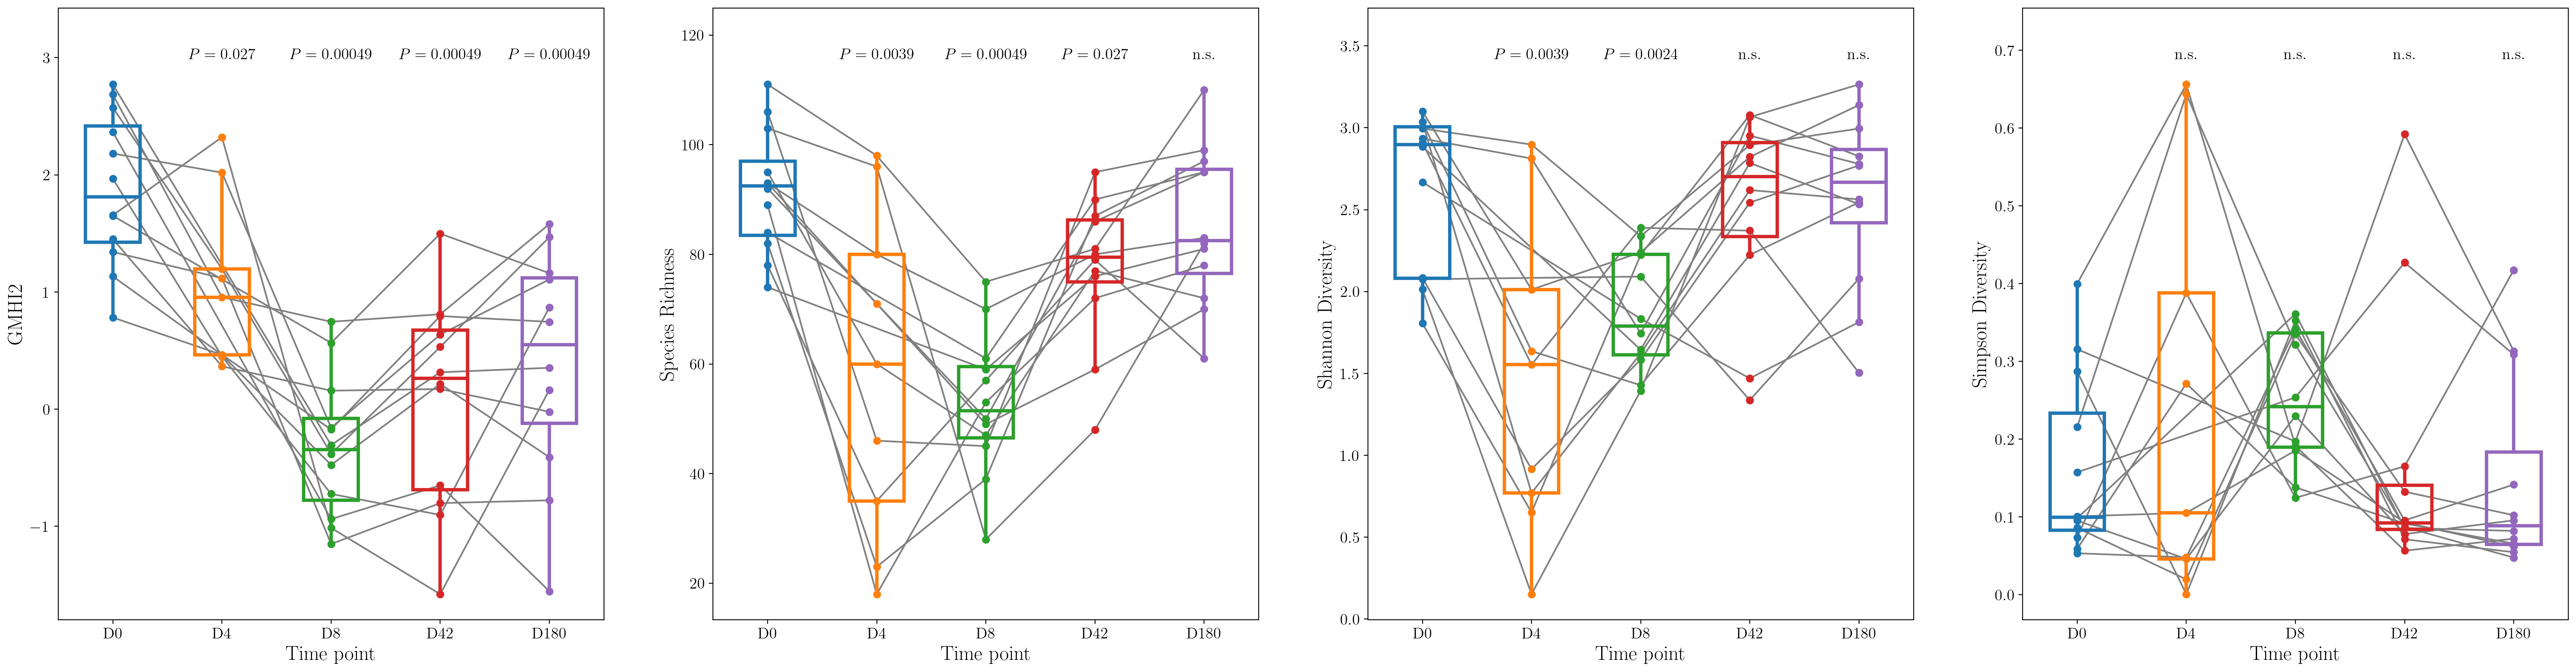

In [11]:
plot_longitudinal(meta, indices, timepoints_sorted, study, show_tau=True)